# MOD510 - Project 2
## Transport in Porous Media - From Laboratory Scale to Field Scale


By: Aleksander B. Jakobsen and Anne H. Amundsen

Date: 18. October 2020

## Abstract
In this project we have learned how to extract data from both lab and field data and compare these.

In the first exercise we import experimental data and use linear regression to estimate the reservoir permeability using Darcy's law.

In exercises 2 and 3 we focus on the pressure inside the reservoir. The line source solution and numerical solvers were created inside a class "RadialDiffusivityEquationSolver" to investigate the pressure changes inside the reservior as a function of distance from the well. We saw that the numerical solvers and the line source solution matched well.

We found that there is a large difference in computational time when using a sparse matrix compared to a regular matrix when solving the matrices. The sparse solvers are more efficient than standard dense solvers.

In exercise 4 the focus shifts to the pressure inside the well and this is compared to experimental data. The default input arguments in the class created in exercise 2 is then changed to get a good fit between the numerical solvers and the experimental data which gives a good indication of the initial pressure, reservior size and reservoir permeability.

Our results show that using the theoretical equations and numerical solvers we can get a good correlation between the experimental data and the numerical data.

## Introduction

Reservoirs are huge porous rocks which may contain gas, water and oil. Permeability is a measure of how easily fluids can flow though the reservoir, where a high permeability means more easily flow compared to a low permability. The flows within the reservoir are driven by pressure differences. 

Opening a reservoir for production might cause pores near the producing well to clog, as a consequence of chemical reactions. A result of this is reduced permeability. Therefore, changes in permeability are monitored using well pressure testing, which is the study of the current project. 

Studying time dependecies in of well pressure gives insights on the properties of the reservoir. Such insights are of significant importance for oil producers. Further, the insights might also be useful for geothermal plants and groundwater applications. 

As mentioned, reservoirs are huge in size. They may vary vertically in sizes 10-100 m and 100-1000 m horizontally. Compared to the reservoir, the well size is significantly smaller, and is typically about half a foot. Despite this difference, the information from a well provides essential information, for example about reservoir size and shape. This project focuses on well pressure testing, and studies the well pressure over time as well as reservoir pressure. Using estimated model paramteres and field data, calculations are made to determine reservoir size and volume.


In [1]:
#import packages needed for all exercises:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve
import scipy as sp
from scipy import special
import scipy.sparse.linalg

## Exercise 1

We will use Darcy's law to calculate the relationship betewen flow rate and pressure when a fluid phase is moving inside a permeable medium. Neglecting gravity and using a consistent set of units, Darcy's law can be expressed as:
\begin{equation}
   \mathbf{u} =-\frac{\mathbf{k}}{\mu}\nabla p
   \label{eq:darcy} \tag{1}
\end{equation}

where $\mathbf{u}[L/T]$ is the Darcy velocity, $\mathbf{k}[L^2]$ is the absolute permeability tensor, $\mu[ML/T]$ is the fluid viscosity, and $p[M/LT^2]$ is fluid pressure.

### Part 1

In Part 1, we consider a homogeneous cylindrical core sample of length $L = 7cm$ and diameter $d = 3.8cm$.

An expression for the volumetric flow rate, $Q$, using Darcy's law above can be shown to be:
\begin{equation}
   Q = \frac{kA}{\mu}\frac{\Delta P}{L}
   \label{eq:flowQ} \tag{2}
\end{equation}
where $A = \pi r^2$ is the cross-sectional area of the core.

A scatter plot of $\Delta P$ versus $Q$ is made from an imported file: __perm_data.dat__. 

In [2]:
# Import data using pandas. Also skipped row with headers to rename without units.
perm_data = pd.read_csv("perm_data.dat", skiprows = 5, sep="\t", names=['q','DP'])

A class has been made combining results for both part 1 and part 2 of exercise 1:

In [3]:
class LinearRegressionPermeability:
    """
    A class with methods to plot data with regression line, find regression coefficient of data,
    and calculate the permeability of the data based on the regression line.
    Input arguments can be given in consistent SI-units
    
    Input arguments:
    perm_data: input data with Q and dP
    length: length of core sample
    diameter: diameter of core sample
    mu: viscocity
    """
    
    def __init__(self, perm_data, length, diameter, mu):
        self.q = perm_data["q"]
        self.DP = perm_data["DP"]
        self.length = length
        self.radius = diameter/2
        self.mu = mu
        
    def plot_scatter_dPvsQ(self):
        """
        Plots scatter plot of dP vs Q and fits a regression line using regression coefficients
        from method: find_regression_coefficients.
        
        Returns
        -------
        None.
        """
        
        # Part 1: Make a scatter plot
        plt.style.use("ggplot")
        plt.scatter(self.DP, self.q)
        plt.xlabel("dP [atm]")
        plt.ylabel("Q [ml/s]")
        plt.title("DP vs Q")
        
        # Part 2: 
        b, a = self.find_regression_coefficients()
        plt.plot(self.DP, a*self.DP+b, color="blue")
        plt.xlim((0,8.1))
    
    
    def find_regression_coefficients(self):
        """
        Returns regression coefficients in ordinary least squares using numpy solve function       

        Returns
        -------
        array of length 2 with coefficients to: y = ax + b
        array[0] = b
        array[1] = a
        """
        #Remove outlier (last point)
        DP = self.DP[:-1]
        q = self.q[:-1]
    
        XT = np.array([np.ones(len(DP)),DP],float)
        X  = np.transpose(XT)
        B = np.dot(XT, X)
        C = np.dot(XT, q)
        return solve(B,C)

    
    def permeability(self):
        """
        Uses the slope coefficient from the regression coefficients to solve equation (2)
        for the permeability k.    
        Returns
        -------
        k : permeability, type: int
        """
        #use slope coefficient from regression coefficients
        b, a = self.find_regression_coefficients() 
        k = (self.mu*self.length*a) / (np.pi*self.radius**2)
        return k

In [4]:
# Setting constants
L = 7 # length in cm
d = 3.8 # diameter in cm
mu = 1 # viscocity in cP

Plot of $\Delta P$ versus $Q$ (from Part 1) and fitted regression line (from Part 2). The last point (outlier) has been removed when making the regression line to make the line a better fit with the data.

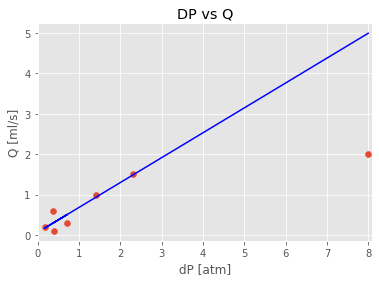

In [5]:
output = LinearRegressionPermeability(perm_data,L,d,mu)
output.plot_scatter_dPvsQ()

Using the slope from the regression line to solve equation (2) for the permeability, $k$.
$$Q = a \Delta P$$ 
where $a = \frac{kA}{\mu L}$ is the slope.

Solving the slope equation for k and inserting for the cross-sectional area, A:
$$k = \frac{\mu a L}{A} = \frac{\mu a L}{\pi r^2}$$
Note: with $L$ and $r$ given in $cm$ and $\mu$ given in $cP$, the unit of $k$ is Darcy ($D$)

In [6]:
permeability = output.permeability()
print(f"The permeability, k, is: {permeability:.3f}D")

The permeability, k, is: 0.381D


## Exercise 2

The theoretical background and assumptions for the exercise can be found in the project description, Section 3, Ref. (1).

The analytical line source solution for the pressure as a function of $r$ and $t$ can be found from Equation (16) in the project description and is repeated below:
\begin{equation}
   p(r,t) = p_i + \frac{Q\mu}{4\pi k h}\cdot \mathcal{W}\left(-\frac{r^2}{4\eta t}\right)
   \label{eq:line_source} \tag{3}
\end{equation}
where $p_i$ is the initial reservoir pressure at infinity, $Q$ is the flow rate, $k$ is the premeability, $h$ is the height of reservoir, $r$ is distance from reservior center, $\eta$ is the diffusion constant, $t$ is time and:
$$\mathcal{W}(x) = \int_{-\infty}^{x} \frac{e^u}{u} \,du$$

### class RadialDiffusivityEquationSolver:

The below class contains combined variables and functions for Exercise 2, 3 and 4. Each exercise is solved with reference to this class.

In [7]:
class RadialDiffusivityEquationSolver:
    """
    A finite difference solver for the radial diffusivity equation.
    We use the coordinate transformation y = ln(r/rw) to set up and
    solve the pressure equation.

    The solver uses SI units internally, while "practical field units"
    are required as input.

    Except for the number of grid blocks / points to use, all class
    instance attributes are provided with reasonable default values.

    Input arguments:

        name                                symbol      unit
        --------------------------------------------------------------
        Number of grid points                N          dimensionless
        well radius                          rw         ft
        extent of reservoir                  re         ft
        height of reservoir                  h          ft
        permeability                         k          mD
        porosity                             phi        dimensionless
        fluid viscosity                      mu         mPas (cP)
        total compressibility                ct         1 / psi
        constant flow rate at well           Q          bbl / day
        initial reservoir pressure           pi         psi
        constant time step                   dt         days
        maximal simulation time          max_time       days
        -------------------------------------------------------------
    """

    def __init__(self, N, rw=0.328, re = 100000., h=8.0,
                 k=500, phi=0.1, mu=1.0, ct=17.7e-6,
                 Q=1000, pi=2000, dt=0.1, max_time=10):

        # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24*60*60
        self.bbl_to_m3_ = 0.1589873

        # Grid
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        self.h_ = h*self.ft_to_m_

        # Rock and fluid properties
        self.k_ = k*1e-15 / 1.01325
        self.phi_ = phi
        self.mu_ = mu*1e-3
        self.ct_ = ct / self.psi_to_pa_
        self.eta_ = self.k_/(self.mu_*self.phi_*self.ct_)

        # Initial and boundary conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_
        self.pi_ = pi*self.psi_to_pa_

        # Time control for simulation
        self.dt_ = dt*self.day_to_sec_
        self.max_time_ = max_time*self.day_to_sec_
        self.current_time_ = 0.
        
        # Convert to y coordinates y = ln(r/rw)
        self.yw_ = np.log(self.rw_/self.rw_)
        self.ye_ = np.log(self.re_/self.rw_)
        self.dy_ = (self.ye_ - self.yw_)/self.N_
        self.y_midpoints_ = (self.dy_)*np.arange(1,self.N_+1,1)-(self.dy_/2)*np.ones(self.N_) #self.N + 1       
        self.r_coords_ = self.rw_ * np.exp(self.y_midpoints_)
        self.y_ = self.dy_*np.arange(self.N_)
        
        self.ksi_ = (self.eta_*np.exp(-2*self.y_midpoints_)*self.dt_)/((self.rw_**2)*(self.dy_**2)) #midpoints istedenfor y
        self.beta_ = (self.Q_*self.mu_*self.dy_)/(2*np.pi*self.k_*self.h_)
        
    
    def line_source_solution(self, r, t):
        """
        Solves the line source solution.
        Eitehr r or t can be given as an array.

        Parameters
        ----------
        r : radius, float or array, input unit feet
        t : time, float or array, input unit day

        Returns
        -------
        p : pressure, output unit Pa

        """
        t = t*self.day_to_sec_ #convert input t form day to sec
        r = r*self.ft_to_m_    #convert input r from ft to m
        #Uses sp.special.expi() to solve W(x)
        p = self.pi_ + ((self.Q_*self.mu_)/(4*np.pi*self.k_*self.h_))*sp.special.expi(-(r**2)/(4*self.eta_*t))
        return p

    def plot_line_source_solution(self, t):
        """
        Plots the analytical line source solution at a specific point in time.
        Parameters
        ----------        
        t: time, unit: days
        """
        re = self.re_ / self.ft_to_m_
        rw = self.rw_ / self.ft_to_m_
        r = np.linspace(rw, re ,1000)
        p = self.line_source_solution(r,t) / self.psi_to_pa_
        plt.style.use("ggplot")
        plt.plot(r,p, label="line source solution")
        plt.xlabel("Radius [ft]")
        plt.ylabel("Pressure [psi]")
        

        
    def plot_line_source_sol_new_r_coords(self, t, marker=False):
        """
        Plots the analytical line source solution at a specific point in 
        time using inverted y-coordinates.
        
        Parameters
        ----------        
        t: time, unit: days
        """
        r_ft = self.r_coords_/self.ft_to_m_
        p = self.line_source_solution(r_ft,t) / self.psi_to_pa_
        if marker == True:
            plt.plot(r_ft,p, 'x', label="line source solution")
        else:
            plt.plot(r_ft,p, label="line source solution")
        plt.xlabel("Radius [ft]")
        plt.ylabel("Pressure [psi]")
        plt.xscale("log") 
        
    def setup_matrix(self):
        """
        Sets up a coefficient matrix as a regular matrix

        Returns
        -------
        A : coefficient matrix

        """
        A = np.zeros(self.N_*self.N_).reshape((self.N_,self.N_))
        A[0][0] = 1 + self.ksi_[0]                          # Boundary condition
        for i in range(1,self.N_):
            A[i][i]= 1 + 2*self.ksi_[i] # mid diagonal
            A[i-1][i] = -self.ksi_[i-1] # upper diagonal
            A[i][i-1] = -self.ksi_[i] # lower diagonal
        A[self.N_-1][self.N_-1] = 1 + self.ksi_[self.N_-1]  # Boundary condition
        return A
        
    def setup_sparse_matrix(self):
        """
        Sets up a sparse coefficient matrix where only non-zero elements are stored

        Returns
        -------
        A_sparse : sparse coefficient matrix

        """
        # Set up diagonals of sparse matrix
        diagonals=np.zeros((3,self.N_))
        for i in range(1, self.N_):
            diagonals[0,i-1]= -self.ksi_[i]                      
            diagonals[1,i]= 1 + 2*self.ksi_[i]
            diagonals[2,i]= -self.ksi_[i-1]      
        # boundary conditions
        diagonals[1,0] = 1 + self.ksi_[0]
        diagonals[1, self.N_-1] = 1 + self.ksi_[self.N_-1]
        # setup sparse matrix from diagonals using scipy
        A_sparse = sp.sparse.spdiags(diagonals, [-1,0,1], self.N_, self.N_,format='csc')
        return A_sparse
        
    def rhs(self,step):
        """
        Sets up right hand side of equation. When step = 0, initial condition is applied.
        
        Parameters
        ----------
        step : time step
        
        Returns
        -------
        b : rhs vector

        """
        #rhs array here:
        if step == 0:
            b = self.pi_*np.ones(self.N_)               # Initial condition
            b[0] -= self.ksi_[0]*self.beta_             # Boundary condition
        else:
            b = self.p
            b[0] -= self.ksi_[0]*self.beta_             # Boundary condition            
        return b
        

    def numerical_sol(self, solver=1):
        """
        Numerical solver for sparse and regular matrix. Default 1 for scipy sparse solver, 
        otherwise numpy solver. 
        Calculates numerical well pressure as a function of time.
        
        Parameters
        ----------
        solver : default 1 for sp.sparse solver, otherwise numpy solver
        
        Returns
        -------
        p : array of pressures along r [Pa]
        pw : array of well pressure along t [Pa]
        time: array of time
        """
        steps = int(self.max_time_/self.dt_)
        pw = np.zeros(steps+1)
        pw[0] = self.pi_-0.5*self.beta_ # initial condition well pressure
        time = self.dt_*np.arange(steps+1)
        # Sparse solver when solver == 1 (default)
        if solver == 1:
            A = self.setup_sparse_matrix()
            for i in range(steps):
                b = self.rhs(i)
                self.p = sp.sparse.linalg.spsolve(A, b)
                pw[i+1] = self.p[0]-0.5*self.beta_              
        # Regular solver when solver != 1
        else:
            A = self.setup_matrix()
            for i in range(steps-1):
                b = self.rhs(i)
                self.p = np.linalg.solve(A, b)
                pw[i+1] = self.p[0]-0.5*self.beta_ 
        p = self.p
        return p, pw, time

### Part 1

In part 1 the methods _line_source_solution(r,t)_ and _plot_line_source_solution(t)_ of the _RadialDiffusivityEquationSolver_ class was made. 

### Part 2
The line source solution is plotted as a function of $r$ from $r = r_w$ to $r = r_e$ at $t = 10$ days.

We see that the pressure increases rapidly from r = 0 to approx r = 2500 m and it reaches $p_i$ and flattens. <br>
This is as expected as the line source solution uses the boundary condition that as $r\rightarrow \infty$, $p\rightarrow p_i$


Text(0.5, 1.0, 'Analytical line source solution')

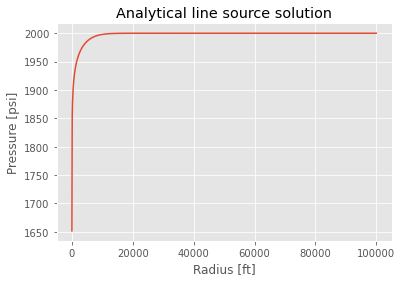

In [8]:
solver = RadialDiffusivityEquationSolver(N=100) #Initialise the solver
solver.plot_line_source_solution(10) #plot line source solution as a function of r at t = 10 days
plt.title("Analytical line source solution")

In [9]:
end_p = solver.line_source_solution(100000,10) #pressure at r = re
print(f"The maximum pressure (t=10 days) is equal to{end_p: .2f}Pa ={end_p/6894.75729: .2f}psi = pi")

The maximum pressure (t=10 days) is equal to 13789514.58Pa = 2000.00psi = pi


### Part 3
Using the coordinate transformation below we can show that we can re-write Equation (11), (12) and (13) in the project description, Ref. (1) into a y-coordinate system. 
\begin{equation}
   y(r) = ln \frac{r}{r_w}
   \label{eq:y_r} \tag{4}
\end{equation}
__Equation (11) in Ref. (1):__
$$\frac{\partial p}{\partial t} = \eta \frac{1}{r} \frac{\partial}{\partial r}\left(r\frac{\partial p}{\partial r}\right)$$
We can use: $\frac{\partial p}{\partial r} = \frac{\partial p}{\partial y}\frac{\partial y}{\partial r}$ 
and insert this into (11):
$$\frac{\partial p}{\partial t} = \eta \frac{1}{r} \frac{\partial}{\partial y}\left(r\frac{\partial p}{\partial y}\frac{\partial y}{\partial r}\right)\frac{\partial y}{\partial r}$$
We can then take the derivative of y in (4) which gives, $\frac{\partial y}{\partial r} = \frac{1}{r}$ and then inserting this into the equation above.
$$\frac{\partial p}{\partial t} = \eta \frac{1}{r} \frac{\partial}{\partial y}\left(r\frac{\partial p}{\partial y}\frac{1}{r}\right)\frac{1}{r}$$
Rearranging Equation (4) gives: $r = r_w e^y$ and we can insert this into the equation above.
$$\frac{\partial p}{\partial t} = \eta \frac{1}{e^{y}r_w} \frac{\partial}{\partial y}\left(e^{y}r_w \frac{\partial p}{\partial y}\frac{1}{e^{y}r_w}\right)\frac{1}{e^{y}r_w}$$
Then differentiating with respect to y: $\frac{\partial e^{y}r_w}{\partial y} = e^{y}r_w$ and rearranging:
$$\frac{\partial p}{\partial t} = \eta \frac{1}{e^{y}r_w}e^{y}r_w \frac{1}{e^{y}r_w}\frac{1}{e^{y}r_w}\frac{\partial}{\partial y}\left(\frac{\partial p}{\partial y}\right)$$
Finally rearranging to get Equation (19) in the project description:
\begin{equation}
   \frac{\partial p}{\partial t} = \eta \frac{e^{-2y}}{r_w^2}\frac{\partial^2 p}{\partial y^2}
   \label{eq:eq19} \tag{5}
\end{equation}

__Equation (12) in Ref. (1):__
$$\frac{2 \pi h k r}{\mu }\frac{\partial p}{\partial r}|_{r=r_w} = Q $$
Using $\frac{\partial p}{\partial r} = \frac{1}{r} \frac{\partial p}{\partial y}$:
$$\frac{2 \pi h k r}{\mu }\frac{1}{r}\frac{\partial p}{\partial y}|_{y=y_w} = Q $$
And rearranging gives Equation (20) in the project description:
\begin{equation}
   \frac{\partial p}{\partial y}|_{y=y_w} = \frac{Q \mu }{2 \pi h k}
   \label{eq:eq20} \tag{6}
\end{equation}



__Equation (13) in Ref. (1):__
$$\frac{\partial p}{\partial r}|_{r=r_e} = 0$$
Using $\frac{\partial p}{\partial r} = \frac{1}{r} \frac{\partial p}{\partial y}$:
$$\frac{1}{r}\frac{\partial p}{\partial y}|_{y=y_e} = 0$$
And rearranging gives Equation (21) in the project description:
\begin{equation}
   \frac{\partial p}{\partial y}|_{y=y_e}
   \label{eq:eq21} \tag{7}
\end{equation}



### Part 4

Created class variables containing y-midpoints and r coordinates for these grid points. This was plotted agains a log r scale for t=10 days and with N=25 to be able to see the individual points.

The new r-coordinates are evenly spaced in a logarithmic scale due to the log definition of the y-coordinates.

Text(0.5, 1.0, 'Analytical line source solution with \nlog r scale and new r-coordinates')

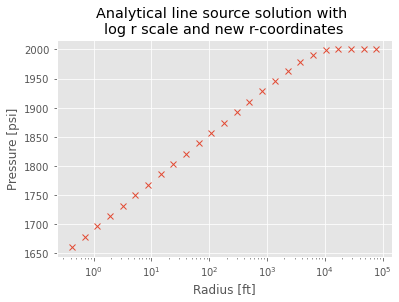

In [10]:
solver2 = RadialDiffusivityEquationSolver(N=25)
x = solver2.plot_line_source_sol_new_r_coords(10, marker=True)
plt.title("Analytical line source solution with \nlog r scale and new r-coordinates")

### Part 5

A numerical scheme for interior grid points is:
\begin{equation}
   \frac{p_{i}^{n+1}-p_{i}^{n}}{\Delta t} = \eta \cdot \frac{e^{-2y}}{r_w^2} \cdot \frac{p_{i+1}^{n+1}+p_{i-1}^{n+1}-2 p_{i}^{n+1}}{\Delta y^2}
   \label{eq:numeric} \tag{8}
\end{equation}

With N = 4 grid points, we write down equation (8) for all four points, $i = 0,1,2,3$. <br>
$i = 0$:
$$\frac{p_{0}^{n+1}-p_{0}^{n}}{\Delta t} = \eta \cdot \frac{e^{-2y}}{r_w^2} \cdot \frac{p_{1}^{n+1}+p_{-1}^{n+1}-2 p_{0}^{n+1}}{\Delta y^2}$$
$i = 1$:
$$\frac{p_{1}^{n+1}-p_{1}^{n}}{\Delta t} = \eta \cdot \frac{e^{-2y}}{r_w^2} \cdot \frac{p_{2}^{n+1}+p_{0}^{n+1}-2 p_{1}^{n+1}}{\Delta y^2}$$
$i = 2$:
$$\frac{p_{2}^{n+1}-p_{2}^{n}}{\Delta t} = \eta \cdot \frac{e^{-2y}}{r_w^2} \cdot \frac{p_{3}^{n+1}+p_{1}^{n+1}-2 p_{2}^{n+1}}{\Delta y^2}$$
$i = 3$:
$$\frac{p_{3}^{n+1}-p_{i}^{n}}{\Delta t} = \eta \cdot \frac{e^{-2y}}{r_w^2} \cdot \frac{p_{4}^{n+1}+p_{2}^{n+1}-2 p_{3}^{n+1}}{\Delta y^2}$$

### Part 6

We start by replacing the derivatives in the boundary conditions by the central finite difference approximation for $ \frac{\partial p}{\partial y} $ and neglecting higher order terms:

$$
\frac{\partial p}{\partial y} = \frac{p^{n+1}_{i+1}-p^{n+1}_{i}}{\Delta y}. 
$$

Then, we may use this in eliminating the boundary conditions:
$$
\frac{\partial p}{\partial y}|_{y=y_w} = \frac{Q \mu} {2\pi h k}
 = \frac{p^{n+1}_{0}-p^{n+1}_{-1}}{\Delta y} 
$$
and
$$
\begin{align}
\frac{\partial p}{\partial y}|_{y=y_e} &= 0 \,  = \frac{p^{n+1}_{4}-p^{n+1}_{3}}{\Delta y} 
\end{align}.
$$

Rewriting these two eqations yields expressions for $p^{n+1}_{-1}$ and $p^{n+1}_{4}$. 

First for $p^{n+1}_{-1}$: 

$$
\frac{Q \mu} {2\pi h k}
 = \frac{p^{n+1}_{0}-p^{n+1}_{-1}}{\Delta y} 
$$
is the same as
$$
p^{n+1}_{-1} = p^{n+1}_{0} - \frac{Q \mu {\Delta y}} {2\pi h k}.
$$


Now for $p^{n+1}_{4}$:
$$
0  = \frac{p^{n+1}_{4}-p^{n+1}_{3}}{\Delta y},
$$
which gives
$$
p^{n+1}_{4} = p^{n+1}_{3}.
$$

We define:
$$
\xi_i = \frac{\eta e^{-2 y_i} \Delta{t}}{r_w^2 \Delta{y}^2}\,,
$$

and
$$
\beta = \frac{Q\mu\Delta y}{2\pi k h}\,.
$$

Using this, we can eliminate $p^{n+1}_{4}$ and $p^{n+1}_{-1}$ from the equations expressed in Exercise 2 - part 5, and acheive the matrix as defined in the exercise. 

First equation: 

$$
\frac{p_{0}^{n+1}-p_{0}^n}{\Delta t}=\eta\cdot\frac{e^{-2y_0}}{r_w^2}\cdot
\frac{p^{n+1}_{1}+p^{n+1}_{-1}-2p^{n+1}_0}{\Delta y^2}
$$

$$
{p_{0}^{n+1}-p_{0}^n}=\xi_0({p^{n+1}_{1}+p^{n+1}_{-1}-2p^{n+1}_0})
$$

$$
{p_{0}^{n+1}-p_{0}^n}=\xi_0({p^{n+1}_{1}+p^{n+1}_{0} - \beta -2p^{n+1}_0})
$$

$$
p_{0}^n - \xi_{0}\beta = (1 + \xi_{0}) p_{0}^{n+1} - \xi_{0}p^{n+1}_1
$$

Second equation:

$$
\frac{p_{1}^{n+1}-p_{1}^n}{\Delta t}=\eta\cdot\frac{e^{-2y_1}}{r_w^2}\cdot
\frac{p^{n+1}_{2}+p^{n+1}_{0}-2p^{n+1}_1}{\Delta y^2}
$$

$$
p_{1}^{n+1}-p_{1}^n = \xi_1({p^{n+1}_{2}+p^{n+1}_{0}-2p^{n+1}_1})
$$

$$
p_{1}^n = - \xi_1 p^{n+1}_{0} + (1 + 2 \xi_1 ) p^{n+1}_1 - \xi_1 p^{n+1}_{2}
$$

Third equation:

$$
\frac{p_{2}^{n+1}-p_{2}^n}{\Delta t}=\eta\cdot\frac{e^{-2y_2}}{r_w^2}\cdot
\frac{p^{n+1}_{3}+p^{n+1}_{1}-2p^{n+1}_2}{\Delta y^2}
$$

$$
p_{2}^{n+1}-p_{2}^n = \xi_2({p^{n+1}_{3}+p^{n+1}_{1}-2p^{n+1}_2})
$$

$$
p_{2}^n = - \xi_2 p^{n+1}_{1} + (1 + 2 \xi_2 ) p^{n+1}_2 - \xi_2 p^{n+1}_{3}
$$

Fourth equation:
$$
\frac{p_{3}^{n+1}-p_{3}^n}{\Delta t}=\eta\cdot\frac{e^{-2y_3}}{r_w^2}\cdot
\frac{p^{n+1}_{4}+p^{n+1}_{2}-2p^{n+1}_3}{\Delta y^2}
$$
$$
p_{3}^{n+1}-p_{3}^n = \xi_3 ( p^{n+1}_{4}+p^{n+1}_{2}-2p^{n+1}_3 )
$$

$$
p_{3}^{n+1}-p_{3}^n = \xi_3 p^{n+1}_{3}+\xi_3 p^{n+1}_{2}- \xi_3 2p^{n+1}_3
$$

$$
p_{3}^n =  - \xi_3 p^{n+1}_{2} + p_{3}^{n+1}(1 + \xi_3)
$$

Combining these in matrix form yields:

$$
\begin{equation}
\underbrace{\begin{pmatrix}
1+\xi_0&-\xi_0&0&0\\ 
-\xi_1&1+2\xi_1&-\xi_1&0\\ 
0&-\xi_2&1+2\xi_2&-\xi_2\\ 
0&0&-\xi_3&1+\xi_3\\ 
\end{pmatrix}}_{\mathbf{A}}
\underbrace{\begin{pmatrix}
p_0^{n+1}\\ 
p_1^{n+1}\\ 
p_2^{n+1}\\ 
p_3^{n+1}\\ 
\end{pmatrix}}_{\mathbf{p}^{n+1}}
=
\underbrace{\begin{pmatrix}
p_0^{n}-\xi_0\beta\\ 
p_1^{n}\\ 
p_2^{n}\\ 
p_3^{n}\\ 
\end{pmatrix}}_{\mathbf{p}^{n}-\mathbf{d}}
\end{equation},
$$

where
$$
\xi_i \equiv \frac{\eta e^{-2 y_i} \Delta{t}}{r_w^2 \Delta{y}^2}\,,
$$

and
$$
\beta \equiv \frac{Q\mu\Delta y}{2\pi k h}\,.
$$

## Exercise 3 - Implement full numerical solution

### Part 1

Three different methods have been implemented in the class *RadialDiffusivityEquationSolver*. These are *setup\_matrix()* to setup a regular coefficient matrix, *setup\_sparse\_matrix()*, to setup a sparse coefficient matrix and *rhs()* to setup the right hand side of the matrix in part 6 of Exercise 2.

### Part 2

A "top-level" function to solve the matrices in part 1 was made as a method in the class *RadialDiffusivityEquationSolver*. This is called *numerical_sol()*

Text(0.5, 1.0, 'Comparison of numerical solvers with \nanalytical line source solution')

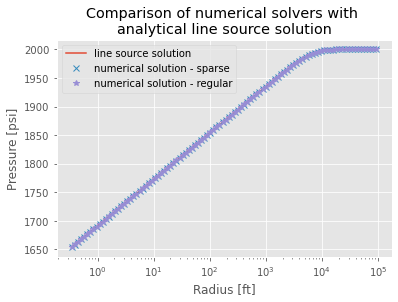

In [11]:
numerical1 = RadialDiffusivityEquationSolver(N=100) #call class with N=100
numerical1.plot_line_source_sol_new_r_coords(10) #plot analytical solution
#Sparse solver
pns, pwns, timens = numerical1.numerical_sol()
#Regular solver
pnr, pwnr, timenr = numerical1.numerical_sol(solver=2)
# Convert r coordinates and pressure back to ft and psi
r_ft = numerical1.r_coords_/numerical1.ft_to_m_
pns_psi = pns/numerical1.psi_to_pa_
pnr_psi = pnr/numerical1.psi_to_pa_

#plot numerical solutions using sparse and regular matrix
plt.plot(r_ft,pns_psi,'x', label="numerical solution - sparse")
plt.plot(r_ft,pnr_psi,'*', label="numerical solution - regular")
plt.legend()
plt.title("Comparison of numerical solvers with \nanalytical line source solution")


Both numerical solvers gives the same solution and this fits well with the analytical line source solution.

### Part 3

The class was initiated with N=1000 grid points and the time was compared for the sparse and regular solver. We can see that the efficiency of the sparse solver is significantly better than regular solver.  

In [12]:
# initiate class with N=1000
numerical2 = RadialDiffusivityEquationSolver(N=1000)
#Sparse solver
%timeit sparse = numerical2.numerical_sol() #sparse default
#Regular solver
%timeit reg = numerical2.numerical_sol(solver = 2)

52.4 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.25 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Exercise 4 - Compare with well data

### Part 1

Data was imported below from __well_test.dat__ and the experimental data was plotted against time. <br>
The well pressure decreases as a function of time. First a rapid decrease the first 100-200 hours and then a linear decrease between approx 500 to 3000 hours.

Text(0.5, 1.0, 'Well pressure vs time')

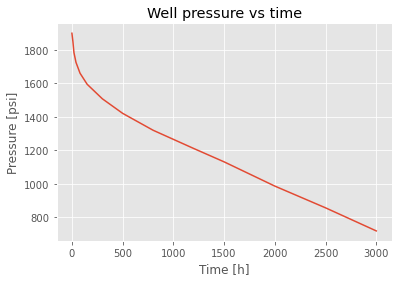

In [13]:
well_data = pd.read_csv("well_test.dat", sep="\t", comment="#")

plt.style.use("ggplot")
plt.plot(well_data["time"], well_data["well_pressure"])
plt.xlabel("Time [h]")
plt.ylabel("Pressure [psi]")
plt.title("Well pressure vs time")

### Part 2

To get the well pressure we can discretize the boundary condition for the well from equation (6) above or equation (20) in the project description, Ref. (1):

$$\frac{\partial p}{\partial y}|_{y=y_w} = \frac{Q \mu }{2 \pi h k}$$

We will do this by using a first order finite difference approximation with step $h = \Delta y / 2$:

$$\frac{\partial p}{\partial y} = \frac{p_{i+1}^{n}-p_{i}^{n}}{\Delta y / 2} = 2\frac{p_{i+1}^{n}-p_{i}^{n}}{\Delta y}$$
Inserting for the well pressure:

$$\frac{\partial p}{\partial y}|_{y=y_w} = 2\frac{p_{0}^{n}-p_{w}^{n}}{\Delta y} = \frac{Q \mu }{2 \pi h k}$$
Solving for $p_w$:

$$p_{w}^{n} = p_{0}^{n} - \frac{Q \mu }{4 \pi h k} = p_{0}^{n} - \frac{1}{2} \beta$$

### Part 3

The numerical solver method *numerical_sol()* in the class *RadialDiffusivityEquationSolver* was updated to include the well pressure calculations in each time step. 

### Part 4
The numerical well pressure data was plotted against time below:

Text(0.5, 1.0, 'Numerical well pressure vs time')

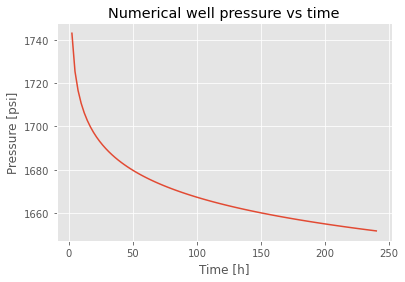

In [14]:
pwns_psi = pwns[1:]/numerical1.psi_to_pa_
time_hrs = timens[1:]/3600
#plotting the well pressure found in the numerical solver against time
plt.plot(time_hrs, pwns_psi)
plt.xlabel("Time [h]")
plt.ylabel("Pressure [psi]")
plt.title("Numerical well pressure vs time")

When plotting the well pressure found by the solver, we see that 10 days is not sufficient to compare to the experimental data. We therefore increase to 125days = 3000hrs. We then plot against the experimental data.

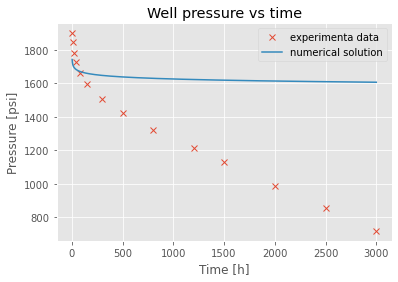

In [15]:
numerical_125 = RadialDiffusivityEquationSolver(N=100, max_time=125)
pns, pwns, timens = numerical_125.numerical_sol()
pwns_psi = pwns[1:]/numerical_125.psi_to_pa_
time_hrs = timens[1:]/3600
#plt.style.use("ggplot")
plt.plot(well_data["time"], well_data["well_pressure"], 'x', label="experimenta data")
plt.plot(time_hrs, pwns_psi, label="numerical solution")
plt.xlabel("Time [h]")
plt.ylabel("Pressure [psi]")
plt.title("Well pressure vs time")
plt.legend()

We see that the numerical solution and experimental data does not match very well.
We try to add the line source solution and use logarithmic scale:

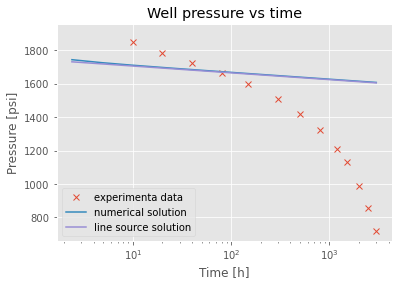

In [16]:
p_ls_psi = numerical_125.line_source_solution(numerical_125.ft_to_m_,time_hrs/24)/numerical_125.psi_to_pa_
plt.plot(well_data["time"], well_data["well_pressure"], 'x', label="experimenta data")
plt.plot(time_hrs, pwns_psi, label="numerical solution")
plt.plot(time_hrs,p_ls_psi, label="line source solution")
plt.xlabel("Time [h]")
plt.ylabel("Pressure [psi]")
plt.title("Well pressure vs time")
plt.legend()
plt.xscale("log")

The line source solution and numerical solution matches well, but does not match the experimental data.
The slope of the numerical and line source solution should match the initial slope of the experimental data.
After a few iterations, it was found that the permeability, $k$ and initial pressure, $p_i$ should updated to approx. $k = 90mD$ and $p_i = 3300psi$

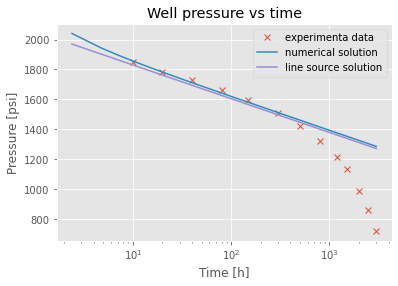

In [17]:
well_pressure_sim = RadialDiffusivityEquationSolver(N=100, max_time=125, k=90, pi=3300)
p, pw, time = well_pressure_sim.numerical_sol()
pw_psi = pw[1:]/well_pressure_sim.psi_to_pa_
time_hrs = time[1:]/3600
p_ls_psi = well_pressure_sim.line_source_solution(well_pressure_sim.ft_to_m_,time_hrs/24)/well_pressure_sim.psi_to_pa_
plt.plot(well_data["time"], well_data["well_pressure"], 'x', label="experimenta data")
plt.plot(time_hrs, pw_psi, label="numerical solution")
plt.plot(time_hrs,p_ls_psi, label="line source solution")
plt.xlabel("Time [h]")
plt.ylabel("Pressure [psi]")
plt.title("Well pressure vs time")
plt.legend()
plt.xscale("log")

The new $k$ and $p_i$ makes the numerical solution and line source solution match the slope of the experimental data well. 

### Part 5

To match the last part of the experimenta data, we have to update the $r_e$ as the rapid decline in pressure is a sign that the wave has reached the end of the reservior.
$r_e = 4300 ft$ was found to be a suitable value to match the data.
The line source solution does not take this into account as is assumes that the reservior is infinite. This has therefore been left out of the plot.


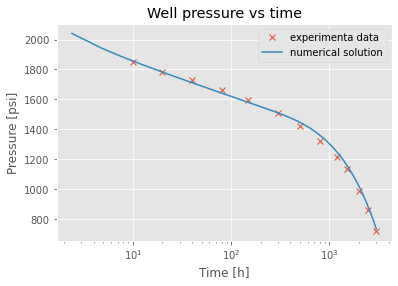

In [18]:
well_pressure_sim2 = RadialDiffusivityEquationSolver(N=100, max_time=125, k=90, pi=3300, re=4300)
p, pw, time = well_pressure_sim2.numerical_sol()
pw_psi = pw[1:]/well_pressure_sim2.psi_to_pa_
time_hrs = time[1:]/3600
plt.plot(well_data["time"], well_data["well_pressure"], 'x', label="experimenta data")
plt.plot(time_hrs, pw_psi, label="numerical solution")
plt.xlabel("Time [h]")
plt.ylabel("Pressure [psi]")
plt.title("Well pressure vs time")
plt.legend()
plt.xscale("log")

We can use the new value for $r_e$ to calculate the size of the reservoir. We assume that the reserviour is a cylinder with radius $r_e$ and height $h$. Then the volume is $V = \pi r^2 h$

In [19]:
volume = (well_pressure_sim2.h_*np.pi*well_pressure_sim2.re_**2)
print(f"Volume of reservior:{volume: .3f} m^3 ={volume/10**9: .4f} km^3")

Volume of reservior: 13158962.790 m^3 = 0.0132 km^3


## Conclusion

What was learned about the methods used, and from the results
obtained? Possible directions and future improvements?

In this project, we learned to use matrix equation to do linear regression using NumPy linear algebra functions. In this work, we also learned to evaluate data-points and classify offset values to drop when implementing the linear regression. The evaluated dataset perm_test.dat yielded one such point which we determined to classify as offset and disregard in the linear regression. 

The diffusitivity equation was studied and solved using an implicit solution method. This required analyzing boundary conditions using the finite difference discretization. Developing both a sparse matrix solver using SciPy as well as a dense matrix solver using NumPy to solve the diffusitivity equation, we got to evaluate the critical differences in runtime of these two methods. We found that the sparse matrix solver using SciPy was significantly better compared to the dense matrix solver using NumPy, when comparing runtime. 

We furhter implemeted a first-order finite difference approximation to determine the well pressure as a function of time. This was compared with measured well pressure data from a well test. The comparison allowed us to adapt model parameters and fit out solution to the well test data. Consequently, using adapted model parameters, we were able to determine the reservoir radius and volume. 

Further work includes testing the model on various data sets to verify the model, and further compare to a reservoir of known size to conclude that the size and radius identified in this project is valid.

## Reflections

In general, this project has been a good way for us to learn more about numerical solvers, linear regression, estimation of model parameters from experimental data and more. It was beneficial to have to implement the solvers from theory and compare to theoretical analytical solutions and experimental data. 

In this project, we decided to both do all the exercises individually and work together to get the best solutions to each problem. We feel that this worked well and it helped both of us reap the learning benefits of the project.

It was some times difficult to understand what the exercise explicitly asked for, however, the TAs helped to clear up everything in the lab exercises.

The background theory was somewhat challenging at times, but explained well so that we did not need external resources to be able to solve the exercises. 

One suggestion for improvement is to introduce classes earlier in the course to prepare the students for the use of classes in this project. We had some prior experience with classes so it was not a problem, but we can imagine that it can be difficult for someone with no prior knowledge of classes and limited experience with python. 

## References

[1] Hiorth, A., 2020, "Transport in Porous Media - From Laboratory Scale to Field Scale. MOD510: Mandatory project 2", UiS <br>
[2] Linear algebra (numpy.linalg), accessed 30. September 2020, \< https://numpy.org/doc/stable/reference/routines.linalg.html \> <br>
[3] scipy.sparse.linalg.spsolve, accessed 30. September 2020, \<https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html#scipy.sparse.linalg.spsolve \> <br>
[4] Slotte, P., Berg, C., 2020, "Lecture note in Well Testing", Department of Geoscience and Petroleum NTNU
